# Dogs vs. cats classification
IFT6135 - Winter 2019

Assigment 1 - Problem 3

Authors: <br>
Stephan Tran <br>
Oussema Keskes <br>
Stefan Wapnick <br>
Mohamed Amine <br>

Inspired by the IFT6135-H19 PyTorch Tutorial

## Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd

## Defining paremeters and variables

In [2]:
RUN_LOCAL = True
VALID_RATIO = 0.10
TRAIN_RATIO = 1.0 - VALID_RATIO
LEARNING_RATE = 0.00001
KERNEL_SIZE = 3
PAD = 1
BATCH_SIZE = 128
MAX_EPOCH = 250

SAVE_MODEL = True  # Save model after each epoch
LOAD_MODEL = False # Skip training phase
SAVE_PATH = 'BestModel.pwf'

if RUN_LOCAL:
    TRAIN_IMG_DIR ='trainset/trainset'
    TEST_IMG_DIR = 'testset/'
else:
    # Kaggle directory
    TRAIN_IMG_DIR ='../input/trainset/trainset'
    TEST_IMG_DIR = '../input/testset'

cuda_available = torch.cuda.is_available()
print(cuda_available)

True



## Importing datasets and preprocessing
1. Load training and testing images
2. Data augmentation: the dataset size will be 5 times larger <br>
    a) Horizontal flipping <br>
    b) Vertical flipping <br>
    c) Rotation <br>
    d) Random combination of all of the above <br>
3. Transform images into tensor so they could be processed
4. Split dataset into training and validation set

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Apply a combination of transforms on all images - 0.5 probability on horizontal and vertical flip
image_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(64, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.48,0.45,0.40), (0.20,0.20,0.20))
])

image_transform_test = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.48,0.45,0.40), (0.20,0.20,0.20))
])


train_dataset = datasets.ImageFolder(root=TRAIN_IMG_DIR, transform=image_transform)
valid_dataset = datasets.ImageFolder(root=TRAIN_IMG_DIR, transform=image_transform_test)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(VALID_RATIO * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# print(len(train_idx), len(valid_idx))
# dataset_size = len(train_dataset)
# train_size = int(TRAIN_RATIO*dataset_size)
# valid_size = dataset_size-train_size

# Dataset splitting (validation - training)
# train_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])


trainset_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE,
                                             num_workers=4, sampler=train_sampler)

validset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 1,
                                             num_workers=4, sampler=valid_sampler)


test_dataset = ImageFolderWithPaths(root=TEST_IMG_DIR, transform=image_transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                              num_workers=4)


# Showing some samples of the training set

In [4]:
def imshow(img):
    x, y = img
    x = x.numpy().transpose((1, 2, 0))
    print(x.shape)
    plt.imshow(x)
    if y == 0:
        print('Meow!')
    else:
        print('Barf!')

# plt.figure()  
# plt.subplot(1,2,1)
# imshow(train_dataset[800])
# plt.subplot(1,2,2)
# imshow(valid_dataset[100])

def get_mean_std(dataset):
    r_mean_list = []
    g_mean_list = []
    b_mean_list = []
    r_std_list = []
    g_std_list = []
    b_std_list = []
    
    for i in range(100):
        x = dataset[10*i][0]
        x = np.asarray(x)
        r_mean, g_mean, b_mean = np.mean(x[0]), np.mean(x[1]), np.mean(x[2])
        r_std,g_std,b_std = np.std(x[0]), np.std(x[1]), np.std(x[2])
        
        r_mean_list.append(r_mean)
        g_mean_list.append(g_mean)
        b_mean_list.append(b_mean)
        r_std_list.append(r_std)
        g_std_list.append(g_std)
        b_std_list.append(b_std)
        
    print(dataset[100][0])
    
    mean = [np.mean(r_mean_list), np.mean(g_mean_list), np.mean(b_mean_list)]
    std = [np.mean(r_std_list), np.mean(g_std_list), np.mean(b_std_list)]        
    
    return mean, std
        
# print(get_mean_std(train_dataset))

## Defining CNN architecture

In [ ]:
# def init_weights(model):
#     if type(model) == nn.Linear:
#         nn.init.uniform_(model.weight)
#         model.bias.data.fill_(0.01)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Layer 1: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
                     
        )        
        # Layer 4: Fully connected
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)

        
    def forward(self, x):
        temp = self.conv(x)
        temp = temp.view(-1,256*4*4)
        temp = self.fc1(temp)
        temp = self.fc2(temp)
        temp = self.fc3(temp)
        temp = torch.sigmoid(temp)
        return temp
    
cnn = Classifier()
if cuda_available:
    cnn = cnn.cuda()

optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# cnn.apply(init_weights)

# Classifier training and validation

In [ ]:
best_epoch = 0
best_acc = 0
log_train_loss = []
log_train_acc = []
log_valid_loss = []
log_valid_acc = []

if LOAD_MODEL == False:
    for epoch in range(MAX_EPOCH):

        train_losses = []
        valid_losses = []

        total = 0
        correct = 0

        ##### TRAINING PHASE ####
        # Set the model in training mode  
        for batch_idx, (inputs, labels) in enumerate(trainset_loader):

            # Data conversion to float and cuda
            labels_flt = torch.tensor(labels, dtype=torch.float)
            if cuda_available:
                inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

            # Compute forward phase
            outputs = cnn(inputs).squeeze()

            # Compute training loss (Binary Cross Entropy)
            loss = criterion(outputs, labels_flt)
            train_losses.append(loss.data.item())
            
            # Prediction: since the output is between 0 and 1 du to sigmoid activation function, the
            # prediction value will be 0 when the output is [0,0.5] and 1 when it is ]0.5,1]
            predicted = outputs > 0.5
            if cuda_available:
                predicted = torch.tensor(predicted, dtype=torch.long).cuda()
            else:
                predicted = torch.tensor(predicted, dtype=torch.long)

            # Compute training accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_acc = 100*correct/total

            # Backward propagation
            loss.backward()
            optimizer.step()

        # Log the training loss and accuracy with respect to the epoch number
        log_train_loss.append([epoch,np.mean(train_losses)])
        log_train_acc.append([epoch,train_acc])

        # Save model into a file for later use
        if SAVE_MODEL:
            if epoch%5 == 0:
                torch.save(cnn.state_dict(), "CNN{0:03d}.pwf".format(epoch)) 


        ##### VALIDATION PHASE ####
        total = 0
        correct = 0    

        # Set the model in evaluation mode
        with torch.no_grad():    
            for batch_idx, (inputs, labels) in enumerate(validset_loader):
                # Data conversion to float and cuda
                labels_flt = torch.tensor(labels, dtype=torch.float)
                if cuda_available:
                    inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

                # Compute forward phase
                outputs = cnn(inputs).squeeze()   

                # Compute validation loss (Binary Cross Entropy)
                loss = criterion(outputs, labels_flt)
                valid_losses.append(loss.data.item())        

                # Prediction
                predicted = outputs > 0.5
                predicted = torch.tensor(predicted, dtype=torch.long).cuda()

                # Compute training accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_acc = 100*correct/total

        # Log the training loss and accuracy with respect to the epoch number
        log_valid_loss.append([epoch,np.mean(valid_losses)])
        log_valid_acc.append([epoch,valid_acc])

        if valid_acc > best_acc:
            best_epoch = epoch
            best_acc = valid_acc      
        print('Epoch : %d Test Acc : %.3f Best epoch: %d Best acc: %.3f' % (epoch, valid_acc , best_epoch, best_acc))
        print('------------------------------------------------------------------------------------')

        
    log_train_loss = np.swapaxes(np.asarray(log_train_loss),0,1)
    log_train_acc = np.swapaxes(np.asarray(log_train_acc),0,1)
    log_valid_loss = np.swapaxes(np.asarray(log_valid_loss),0,1)
    log_valid_acc = np.swapaxes(np.asarray(log_valid_acc),0,1)

else:
    cnn.load_state_dict(torch.load(SAVE_PATH))
    cnn.eval()

/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([1])) that i

Epoch : 0 Test Acc : 49.975 Best epoch: 0 Best acc: 49.975
------------------------------------------------------------------------------------
Epoch : 1 Test Acc : 49.975 Best epoch: 0 Best acc: 49.975
------------------------------------------------------------------------------------
Epoch : 2 Test Acc : 54.727 Best epoch: 2 Best acc: 54.727
------------------------------------------------------------------------------------
Epoch : 3 Test Acc : 50.325 Best epoch: 2 Best acc: 54.727
------------------------------------------------------------------------------------
Epoch : 4 Test Acc : 50.025 Best epoch: 2 Best acc: 54.727
------------------------------------------------------------------------------------
Epoch : 5 Test Acc : 50.025 Best epoch: 2 Best acc: 54.727
------------------------------------------------------------------------------------
Epoch : 6 Test Acc : 50.025 Best epoch: 2 Best acc: 54.727
-----------------------------------------------------------------------------

## Plot training and validation loss/accuracy

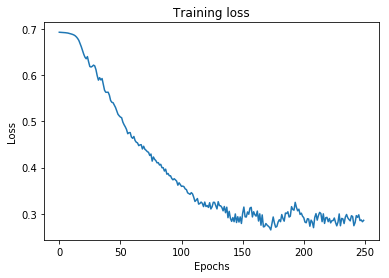

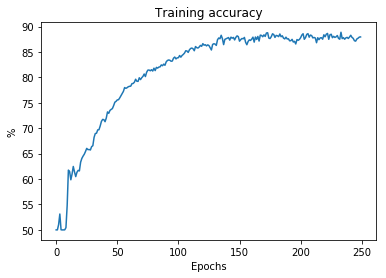

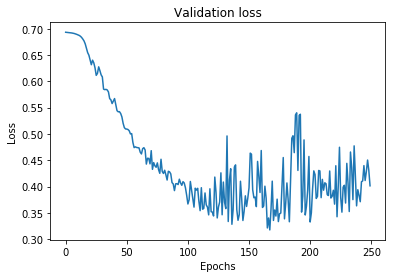

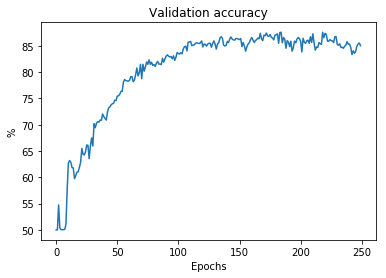

In [ ]:
if LOAD_MODEL == False:
    plt.figure(1)
    plt.plot(log_train_loss[0], log_train_loss[1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.savefig('train_loss.png')
    
    plt.figure(2)
    plt.plot(log_train_acc[0], log_train_acc[1])
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.title('Training accuracy')
    plt.savefig('train_acc.png')

    plt.figure(3)
    plt.plot(log_valid_loss[0], log_valid_loss[1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation loss')
    plt.savefig('valid_loss.png')

    plt.figure(4)
    plt.plot(log_valid_acc[0], log_valid_acc[1])
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.title('Validation accuracy')
    plt.savefig('valid_acc.png')
    
    plt.show()


## Predicting test dataset

In [ ]:
header = ['id', 'label']
prediction = []

with torch.no_grad(): 
    for batch_idx, (inputs, labels, paths) in enumerate(test_loader):
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()   
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = outputs > 0.5
        predicted = torch.tensor(predicted, dtype=torch.long).cuda()    

        filename = os.path.basename(paths[0])
        filename = os.path.splitext(filename)[0]

        if predicted == 0:
            data_out = [filename, 'Cat']
        else:
            data_out = [filename, 'Dog']
        prediction.append(data_out)


image_name = np.asarray(prediction)[:,0]
label = np.asarray(prediction)[:,1]
submission = pd.DataFrame({ 'id': image_name, 'label': label })
submission.to_csv("my_submission.csv", index=False)
    

/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


## Visualize misclassification and uncertain classification

/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


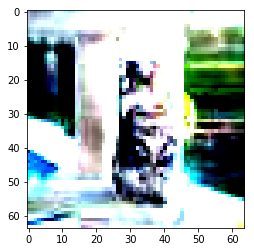

In [ ]:
# total = 0
# correct = 0
# with torch.no_grad():    
#     for batch_idx, (inputs, labels) in enumerate(validset_loader):
#         # Data conversion to float and cuda
#         labels_flt = torch.tensor(labels, dtype=torch.float)
#         if cuda_available:
#             inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

#         # Compute forward phase
#         outputs = cnn(inputs).squeeze()   

#         # Prediction
#         predicted = outputs > 0.5
#         predicted = torch.tensor(predicted, dtype=torch.long).cuda()

#         # Compute training accuracy
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         valid_acc = 100*correct/total
        
#         img_list = inputs.cpu().numpy()
#         img_list = np.squeeze(img_list)
        
#         print(batch_idx)
        
#         # Show misclassification
#         if predicted != labels:
#             img = img_list
#             img = np.transpose(img,(1, 2, 0))
#             plt.figure(1)
#             plt.imshow(img)
#             plt.show()            
#             input('Misclassification: Prob. of %.3f' %  outputs)
                    
        
#         # Hard decision
# #         outputs_np = np.asarray(outputs.cpu())
# #         hard_idx = np.where(abs(outputs_np - 0.50) < 0.05)
# #         hard_idx = hard_idx[0][0]
        
#         if (outputs < 0.55) and (outputs > 0.45):
#             img = img_list
#             img = np.transpose(img,(1, 2, 0))
#             plt.figure(2)
#             plt.imshow(img)
#             plt.show()
#             input('Hard decision: Prob. of %.3f and is %d' %  (outputs,labels))